In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding
from keras.models import load_model
from tensorflow.keras.utils import plot_model

2.4.1


In [3]:
sequence_length=10
min_word_frequency=20
step=1
batch_size=64

**Shuffle and split training set**

In [4]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [5]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length), dtype=np.int32)
    y=np.zeros((batch_size), dtype=np.int32)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t]=word_indices[w]
      y[i]=word_indices[next_word_list[index%len(sentence_list)]]
      index+=1                                             
    yield x, y

**Write generated vocabulary to a file**

In [6]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [7]:
def get_model(dropout=0.2):
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Embedding(input_dim=len(words), output_dim=1024))
    model.add(Bidirectional(LSTM(700, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(700, return_sequences=True)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(700)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model

In [8]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [9]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length))
      for t, word in enumerate(sentence):
        x_pred[0, t]= word_indices[word]
      ##print("Generating predictions...")
      preds=model.predict(x_pred, verbose=0)[0]
      #print("Done!")
      #print("Generating next index...")
      next_index=sample(preds, diversity)
      #print("Done!")
      #print("Generating next word...")
      next_word=indices_word[next_index]
      #print("Done!")
      #print("Updating sentence value...")
      sentence=sentence[1:]
      #print("Done!")
      #print("Appending to sentence...")
      sentence.append(next_word)
      #print("Done!!!!!!!!!")
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Jim Butcher**

In [10]:
##corpus_tg='/content/gdrive/MyDrive/Project folder/Author text files/Terry Goodkind.txt'
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Jim Butcher.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_jim_butcher.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_jim_butcher.txt'

In [11]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Jim Butcher/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Jim Butcher/checkpoints')

In [12]:
#file_tg=open(corpus_tg, encoding='utf8')
#text_tg=file_tg.read().lower().replace('\n', '\n ')
#print(len(text_tg))

In [13]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 16846180


In [14]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 3043648


In [15]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [16]:
len(word_freq)

108275

In [17]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [18]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
print_vocabulary(vocabulary, words)

Unique words before ignoring: 108275
Unique words after ignoring: 10461


In [19]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [20]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [21]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  1956394
Remaning sentences:  1087244
Number of words:  1087244


In [22]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 1065499
Size of test set= 21745


In [23]:
model=get_model()

Build model...
Done!


In [24]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

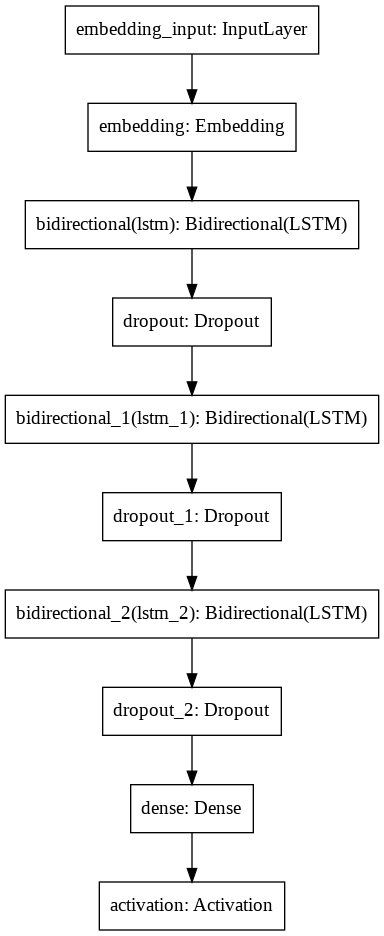

In [25]:
plot_model(model, to_file='Jim Butcher model.png')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 1024)        10712064  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 1400)        9660000   
_________________________________________________________________
dropout (Dropout)            (None, None, 1400)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 1400)        11765600  
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 1400)        0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1400)              11765600  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1400)              0

In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/Jim Butcher/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
int(len(sentences_test)/batch_size)+1

340

In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/Jim Butcher/checkpoints/METG-epoch001-words10461-sequence10-minfreq20-loss4.5490-accuracy0.2072-val_loss4.8023-val_accuracy0.2125"
from keras.models import load_model
model=load_model(model_file)

In [ ]:
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Jim Butcher/model_jim_butcher.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Jim Butcher/model_jim_butcher.h5")
print("Saved model to disk!")

Saved model to disk!


In [ ]:
##model=get_model()
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_jim_butcher.h5")

In [ ]:
with tf.device('/gpu:0'):
  history=model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=10, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
 3822/16649 [=====>........................] - ETA: 28:57 - loss: 4.6053 - accuracy: 0.2115

In [ ]:
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Jim Butcher/model_jim_butcher.json", "w") as json_file:
    json_file.write(model_json)
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Jim Butcher/model_jim_butcher.h5")
print("Saved model to disk!")

**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, 
                  seed, sequence_length, diversity, 
                  quantity, vocabulary, write_path, 
                  write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length))
    for t, word in enumerate(sentence):
      x_pred[0, t]= word_indices[word]
    ##print("Generating predictions...")
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
##vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_jim_butcher.txt"

In [ ]:
##model=load_model(model_file)
##vocabulary=open(vocabulary_file, "r").readlines()
##print(len(vocabulary))

In [ ]:
#import re
#vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
#word_indices=dict((c, i) for i, c in enumerate(words))
#indices_word=dict((i, c) for i, c in enumerate(words))

For generating essays with 250 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=250
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Jim Butcher/", 
                True, "Jim Butcher")
  print("=====================================================")

Seed sentence: could afford to pay that price. tavi did not think
====Generating text====
Diversity:  0.3
Seed sentence: could afford to pay that price. tavi did not think
could afford to pay that price. tavi did not think think of his own emotions and his own body was
 gone. the blow was a single cloud of smoke and
 the sound of a cloud of sparks and dust and
 fangs and ice and the canim had been cut into
 a cloud of heavy light, and the knights aeris were
 the same way to the city of the city of
 the realm. and they were still in the dark, and
 the canim had been all the way to the city
 of the first aleran of the first aleran in the
 first aleran of alera, and their ritualists were one of
 them in the first aleran and the first aleran had
 been the first aleran of the first lord and the
 knights terra had been in the same way to the
 city of the city. the canim had been taken from
 the city and the canim had been a long time
 ago. the vord had been the first lord and the
 knights ae

For generating a small essay of 300 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=300
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Jim Butcher/", 
                True, "Jim Butcher")
  print("=====================================================")

Seed sentence: said quietly. "but can we do it? without the firecrafters
====Generating text====
Diversity:  0.3
Seed sentence: said quietly. "but can we do it? without the firecrafters
said quietly. "but can we do it? without the firecrafters firecrafters of the crown. the vord had been a cloud
 of dark light, and the canim had been a long
 time to move in the first place, and the first
 lord had been a lot more than a hundred feet
 away. the snow was a solid and delicate sound of
 the sound of the canim in the center of the
 courtyard, and the legionares , and the canim had been
 a great deal more than a hundred feet across. the
 first lord was on the way to the valley of
 the city and the canim had been a single sort
 of rushing down the hill of the bed. it was
 a small sound of the wind and the table of
 the crown, and the vord had already been a great
 deal more than a few moments before the first lord
 had been a great deal more than a handful of
 ambitious trees in the room, and

For generating novels with 10000 words

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10000
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Jim Butcher/", 
                True, "Jim Butcher")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 do that." "i can't do all right now, but you
 got a bloody good and a long, heavy life with
 the water was still in the water as it began
 to glow that the ice in a cloud of pure
 motion. the other side of the wall was very far
 away, and i was a young man who had been
 a good one, but he was a big man, for
 a few seconds. he was still in the first place,
 and he was going to be able to get out
 of the way around the gate. i turned the arm
 toward my aching leg. i felt the sudden sense of
 my amulet as i could not move through the empty
 space as i entered the stairway and fell to the
 ground with a flickering mass of flickering light and a
 short, single not cloud of motion. i had a feeling
 that was the first time i'd seen the lives of
 a wind and alien wards. the lights had simply been
 a single man, and it was more flame, to their
 own body. tavi suddenly felt like a surge of sparks
 and blood. the lights were spread from the surf

For generating novels with 10500 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Jim Butcher/", True, "Jim Butcher")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 impact and the gargoyle attached to the ground with a
 single rush of pure force that looked like a single
 cloud of glowing light, and the knot of impact and
 the fires of the canim had been the same way
 to the first lord, and the canim had been a
 solid area of the city in the first aleran and
 the lords of outer night and the canim had been
 a great deal more than a few moments of the
 same black court of the realm. the vord had been
 the first lord of the white council. she was a
 young man who had been a lot more than a
 hundred feet across. the first lord had been a long
 time since the canim had been a great deal more
 than a few moments ago. i had to be able
 to get to the next few moments. i saw her
 and the knife in her hand as she came back
 to the bar, and she looked up at the tent.
 she looked at the door, and she turned to the
 door, then said, “i don’t think you know what i
 do to you to do with the first lord’s wife
 

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.8, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Jim Butcher/", True, "Jim Butcher")
  print("=====================================================")

Seed sentence: the park, in no great hurry, talking and laughing as
====Generating text====
Diversity:  0.8
Seed sentence: the park, in no great hurry, talking and laughing as
the park, in no great hurry, talking and laughing as as the canim dropped into the blankets on the side
 of the shelf. the one to the i said to
 the shieldwall hearing the gate before i could think the
 second man might have been gone. i might have been
 able to get the right ass through here as he
 was involved in my life. i hadn't been feeling a
 baseball of the night. i needed to have not all
 of him. like the sound of the creatures was careful.
 that was in the way around a kiss. the concrete
 was still for the eyes of the deaths of hooded
 silence and the combat that had been overwhelmed with the
 of the keepers and a cloud of air in the
 city. i saw running the duck and fell to the
 ground as she went. she could sense it into his
 leg. he was swift and wrong if he had not
 seen a man, the storm was simply a